In [245]:
from dataclasses import dataclass
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt

In [246]:
def create_uniform_nodes(N_intervals):
    x_nodes = jnp.linspace(0.0, 1.0, N_intervals+1)
    return x_nodes

In [247]:
def mesh_points(N, index: int):
    # Retourne les bords gauche/droit des cellules pour une partition uniforme de [0,1].
    # `N` est le nombre d'intervalles (ou cellules). create_uniform_nodes(N) renvoie N+1 noeuds.
    x_nodes = create_uniform_nodes(N)
    # les bords des cellules sont simplement les noeuds consécutifs
    xL = x_nodes[:-1]
    xR = x_nodes[1:]
    return xL, xR

In [248]:
x_gauss = jnp.linspace(0, 1, 11)
N_cell = len(x_gauss) - 1
print("Gauss points:", x_gauss)
xL, xR = mesh_points(N_cell, 1)
print("Left mesh points:", xL)
print("Right mesh points:", xR)

Gauss points: [0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004 1.        ]
Left mesh points: [0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004]
Right mesh points: [0.1        0.2        0.3        0.4        0.5        0.6
 0.7        0.8        0.90000004 1.        ]


In [249]:
mesh_points_result = mesh_points(N_cell, jnp.arange(1, N_cell))
print("Left mesh points:", mesh_points_result[0])
print("Right mesh points:", mesh_points_result[1])

Left mesh points: [0.         0.1        0.2        0.3        0.4        0.5
 0.6        0.7        0.8        0.90000004]
Right mesh points: [0.1        0.2        0.3        0.4        0.5        0.6
 0.7        0.8        0.90000004 1.        ]


In [250]:
def phi(x, xi, a):
    """
    x : point réel où évaluer la base
    xi : tuple (xL, xR) de la cellule
    a : indice de la base locale (0 ou 1 pour P1)
    """
    xL, xR = xi
    
    # vérifier si x est dans la cellule
    in_cell = (x >= xL) & (x <= xR)
    
    # mapping vers l'élément de référence [-1,1]
    xi = 2*(x - xL)/(xR - xL) - 1
    
    # base DG P1
    val = jnp.where(a==0, 0.5*(1-xi), 0.5*(1+xi))
    
    # mettre à zéro en dehors de la cellule
    return jnp.where(in_cell, val, 0.0)

# Vectorize over cells: x is passed whole (None), x_left/x_right/a are mapped over axis 0
vmap_phi = jax.vmap(phi, in_axes=(None, 0, None))

In [251]:
N = 5
x_nodes = jnp.linspace(0, 1, N)
xLs, xRs = mesh_points(N-1, 1)

x = 0.4
xis = (xLs, xRs)
print("xLs:", xLs)
print("xRs:", xRs)

values_a0 = vmap_phi(x, xis, 0)
values_a1 = vmap_phi(x, xis, 1)
print(values_a0, values_a1)

xLs: [0.   0.25 0.5  0.75]
xRs: [0.25 0.5  0.75 1.  ]
[0.         0.39999998 0.         0.        ] [0.  0.6 0.  0. ]


In [252]:
print("xLs:", xLs)
print("xRs:", xRs)
print("xi:", xis)
print("values_a0:", values_a0)
print("values_a1:", values_a1)

xLs: [0.   0.25 0.5  0.75]
xRs: [0.25 0.5  0.75 1.  ]
xi: (Array([0.  , 0.25, 0.5 , 0.75], dtype=float32), Array([0.25, 0.5 , 0.75, 1.  ], dtype=float32))
values_a0: [0.         0.39999998 0.         0.        ]
values_a1: [0.  0.6 0.  0. ]


In [253]:
# Nombre de cellules
N_cells = 10
xLs = jnp.linspace(0, 1-1/N_cells, N_cells)
xRs = jnp.linspace(1/N_cells, 1, N_cells)
# Points pour le tracé
X_plot = jnp.linspace(0, 1, 500)

Text(0.5, 1.0, 'Fonctions de base DG-P1 sur 10 cellules')

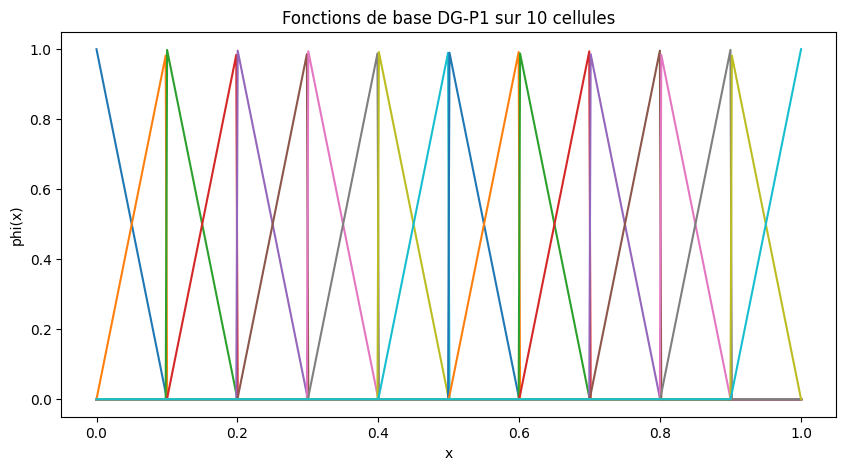

In [254]:
all_bases = []
for k in range(N_cells):
    for a in [0, 1]:
        Y = jnp.array([phi(x, (xLs[k], xRs[k]), a) for x in X_plot])
        all_bases.append(Y)

# Tracé
plt.figure(figsize=(10,5))
for i, Y in enumerate(all_bases):
    plt.plot(X_plot, Y, label=f'cell {i//2}, base {i%2}')
plt.xlabel('x')
plt.ylabel('phi(x)')
plt.title('Fonctions de base DG-P1 sur 10 cellules')

In [255]:
def Mass_Matrix(x_nodes, n_quad=100):
    # x_nodes : array of node positions (length N_nodes)
    N_nodes = x_nodes.size
    if N_nodes < 2:
        raise ValueError("x_nodes must contain at least two nodes")

    # construct cell boundaries
    xLs = x_nodes[:-1]
    xRs = x_nodes[1:]
    num_cells = xLs.size
    num_dofs = 2 * num_cells  # P1 DG: 2 local bases per cell

    # compute local mass matrices cell-by-cell and return an array of shape (num_cells,2,2)
    def local_mass(i):
        xL = xLs[i]
        xR = xRs[i]
        # quadrature on [xL,xR]
        xq = jnp.linspace(xL, xR, n_quad)
        dxq = xq[1] - xq[0]
        w = jnp.ones(n_quad) * dxq
        w = w.at[0].set(dxq / 2)
        w = w.at[-1].set(dxq / 2)
        # evaluate local basis functions at quadrature points
        phi0 = jax.vmap(lambda xx: phi(xx, (xL, xR), 0))(xq)
        phi1 = jax.vmap(lambda xx: phi(xx, (xL, xR), 1))(xq)
        M00 = jnp.sum(w * phi0 * phi0)
        M01 = jnp.sum(w * phi0 * phi1)
        M11 = jnp.sum(w * phi1 * phi1)
        return jnp.array([[M00, M01], [M01, M11]]) # scaling for reference element

    indices = jnp.arange(num_cells)
    M_local = jax.vmap(local_mass)(indices)  # shape (num_cells, 2, 2)
    
    # compute inverses of each local block
    M_inv_local = jax.vmap(jnp.linalg.inv)(M_local)  # shape (num_cells, 2, 2)

    return M_local, M_inv_local

# return local matrices and their inverses
M_local, M_inv_local = Mass_Matrix(x_nodes)
print('M_local.shape', M_local.shape)
print('M_inv_local.shape', M_inv_local.shape)
print('First local block:', M_local[0])

M_local.shape (4, 2, 2)
M_inv_local.shape (4, 2, 2)
First local block: [[0.08333759 0.04166241]
 [0.04166241 0.08333759]]


In [266]:
def volume_func(u, j, N, Flux):
    """Compute local volume integrals for cell `j` and return two local DOFs (P1 DG)."""
    # build nodes and cell boundaries
    x_nodes = create_uniform_nodes(N)
    xLs = x_nodes[:-1]
    xRs = x_nodes[1:]
    # select cell boundaries for index j
    xL = xLs[j]
    xR = xRs[j]
    h  = xR - xL
    

    # simple quadrature on the cell [xL,xR] (rectangle rule with nq points)
    nq = 100
    xq = jnp.linspace(xL, xR, nq)
    w  = jnp.ones(nq) * (h/(nq-1))
    w  = w.at[0].set(h/(2*(nq-1)))
    w  = w.at[-1].set(h/(2*(nq-1)))

    uq = u(xq)
    Fq = Flux(uq)

    dphi0 = -1.0 / h
    dphi1 =  1.0 / h

    V0 = jnp.sum(w * Fq * dphi0)
    V1 = jnp.sum(w * Fq * dphi1)

    return jnp.array([V0, V1])

volume_func_V = jax.vmap(volume_func, in_axes=(None, 0, None, None))



In [267]:
def rusanov_flux(uL, uR, Flux, a):
    return 0.5 * (Flux(uL) + Flux(uR)) - 0.5 * a * (uR - uL)

    

In [268]:
def surface_term(u_cells, j, Flux, a):
    uL = u_cells[j]
    uR = u_cells[j+1]

    fR = rusanov_flux(uL[1], uR[0], Flux, a)
    fL = rusanov_flux(u_cells[j-1][1], u_cells[j][0], Flux, a)

    # valeurs de phi aux bords
    phiR = jnp.array([0., 1.])
    phiL = jnp.array([1., 0.])

    return fR * phiR - fL * phiL

In [269]:
def dg_step(u, u_cells, Flux, M_inv_local, dt, a):
    """DG step using local 2x2 mass matrix blocks."""
    def update_cell(j):
        V = volume_func(u, j, N, Flux)
        S = surface_term(u_cells, j, Flux, a)
        # M_inv_local has shape (N, 2, 2), use the j-th block for cell j
        return u_cells[j] + dt * (M_inv_local[j] @ (V - S))

    return jax.vmap(update_cell)(jnp.arange(1, N-1))

In [270]:
#fonction erreur
def error_L2(u_pred: jnp.ndarray, u_true: jnp.ndarray):
    return jnp.sqrt(jnp.sum((u_pred - u_true)**2) / u_true.shape[0])


In [273]:
f = lambda x: jnp.sin(2 * jnp.pi * x) * jnp.exp(-5 * x)
N=200
u_fun = jax.vmap(f)
u_cells = jax.vmap(lambda xL, xR: jnp.array([f(xL), f(xR)]))(xLs, xRs)

def Flux(u):
    c=1.0
    return c*u

dt = 0.01
a = 1.0  # vitesse maximale pour le flux de Rusanov
M_local, M_inv_local = Mass_Matrix(x_nodes)
u_pred = dg_step(u_fun, u_cells, Flux, M_inv_local, dt, a)

L2 error: 0.51508963


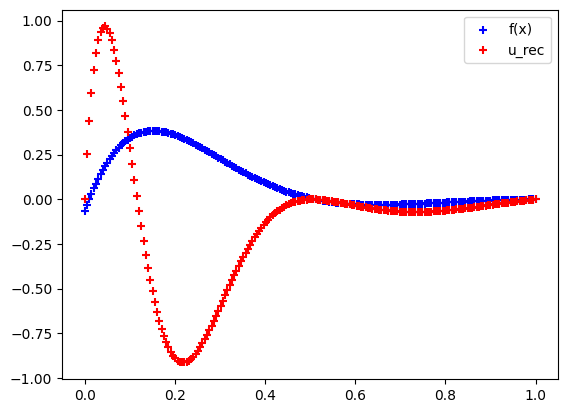

In [274]:
# Visualisation
# u_pred has shape (N-2, 2) for cells 1 to N-2
# Reconstruct full DG coefficient vector: add boundary cells
u_full = jnp.zeros((N, 2))
u_full = u_full.at[1:N-1].set(u_pred)  # cells 1 to N-2 from dg_step
u_full = u_full.at[0].set(jnp.array([f(xLs[0]), f(xRs[0])]))  # boundary cell 0
u_full = u_full.at[N-1].set(jnp.array([f(xLs[N-1]), f(xRs[N-1])]))  # boundary cell N-1

# Flatten to DOF ordering: [c0a0,c0a1,c1a0,c1a1,...]
u_dof = u_full.ravel()

x_test = jnp.linspace(0, 1, N)
x_nodes = create_uniform_nodes(N)
xLs = x_nodes[:-1]
xRs = x_nodes[1:]

def eval_u_at(x):
	v0 = vmap_phi(x, (xLs, xRs), 0)
	v1 = vmap_phi(x, (xLs, xRs), 1)
	stacked = jnp.stack([v0, v1], axis=1).ravel()
	return jnp.dot(stacked, u_dof)

u_rec = jax.vmap(eval_u_at)(x_test)

print("L2 error:", error_L2(u_rec, f(x_test-dt)))
plt.scatter(x_test, f(x_test-dt), marker='+', color='blue', label='f(x)')
plt.scatter(x_test, u_rec, marker='+', color='red', label='u_rec')
plt.legend()
